In [1]:
import pandas as pd
from metrics import get_metrics, plot_pr_curve, get_gt_and_proba, plot_roc_curve
import matplotlib.pyplot as plt
import numpy as np

Читаю csv-файлы в датафреймы и изучаю как выглядят данные

In [2]:
gt = pd.read_csv('mini_dataset/groundtruth.csv')
preds = pd.read_csv('mini_dataset/predictions.csv')

In [3]:
preds

,clip_name,frame_num,obj_type,x,y,w,h,confidence
0,20191216_123222.mp4,4,SeatbeltNo,146,478,294,242,0.980469
1,20191216_123222.mp4,4,Eyes,202,356,106,52,0.003906
2,20191216_123222.mp4,4,Face,206,328,124,148,0.000000
3,20191216_123222.mp4,4,Mouth,208,414,106,52,0.003906
4,20191216_123222.mp4,5,SeatbeltNo,146,478,288,242,0.984375
...,...,...,...,...,...,...,...,...
120057,20191216_125644.mp4,5101,Mouth,272,426,116,58,0.003906
120058,20191216_125644.mp4,5102,SeatbeltNo,240,426,318,294,0.992188
120059,20191216_125644.mp4,5102,Glasses,252,362,150,72,0.788163
120060,20191216_125644.mp4,5102,Face,268,328,142,164,0.000000


In [4]:
gt

,clip_name,frame_num,obj_type,x,y,w,h,label
0,20191216_124707.mp4,1,Face,331,268,170,219,Straight
1,20191216_124707.mp4,1,Eyes,354,359,117,39,Open
2,20191216_124707.mp4,1,Mouth,379,435,63,23,Close
3,20191216_124707.mp4,2,Face,331,268,170,219,Straight
4,20191216_124707.mp4,2,Eyes,354,359,117,39,Open
...,...,...,...,...,...,...,...,...
110403,20191216_123222.mp4,5116,Mouth,285,447,58,24,Close
110404,20191216_123222.mp4,5117,Face,220,287,167,206,Straight
110405,20191216_123222.mp4,5117,Glasses,233,383,152,39,Unknown
110406,20191216_123222.mp4,5117,Eyes,266,373,108,39,Unknown


In [5]:
gt[gt['obj_type'] == 'Face']['label'].value_counts()

Straight    17128
Unknown      4417
Side         3979
Down         1822
Up           1445
Name: label, dtype: int64

In [6]:
gt['obj_type'].value_counts()

Face         28791
Eyes         28681
Mouth        28651
Glasses      19828
Cellphone     4457
Name: obj_type, dtype: int64

In [7]:
preds['obj_type'].value_counts()

Face           28661
Mouth          28661
SeatbeltNo     28176
Glasses        16880
Eyes            8718
Cellphone       4992
Sunglasses      3358
SeatbeltYes      616
Name: obj_type, dtype: int64

In [8]:
obj_types = gt['obj_type'].unique()

In [9]:
preds = preds[preds['obj_type'].isin(obj_types)]

In [10]:
preds['obj_type'].value_counts()

Face         28661
Mouth        28661
Glasses      16880
Eyes          8718
Cellphone     4992
Name: obj_type, dtype: int64

Пример кадра, на котором есть метки, которые модель не распознала (False Negative)

In [11]:
gt.loc[(gt['clip_name'] == '20191216_123222.mp4') & (gt['frame_num'] == 3592)]

,clip_name,frame_num,obj_type,x,y,w,h,label
103401,20191216_123222.mp4,3592,Face,195,278,190,245,Unknown
103402,20191216_123222.mp4,3592,Glasses,213,400,156,60,Unknown
103403,20191216_123222.mp4,3592,Eyes,235,412,117,35,Unknown
103404,20191216_123222.mp4,3592,Mouth,269,480,56,25,Close
103405,20191216_123222.mp4,3592,Cellphone,300,700,84,20,Hard


In [12]:
preds.loc[(preds['clip_name'] == '20191216_123222.mp4') & (preds['frame_num'] == 3592)]

,clip_name,frame_num,obj_type,x,y,w,h,confidence
14548,20191216_123222.mp4,3592,Glasses,224,402,146,62,0.769557
14549,20191216_123222.mp4,3592,Face,230,368,126,160,0.000000
14550,20191216_123222.mp4,3592,Mouth,238,464,114,56,0.003906


Пример кадра, на котором модель ложно распознала метки, которых нет (False Positive)

In [13]:
gt.loc[(gt['clip_name'] == '20191216_123222.mp4') & (gt['frame_num'] == 68)]

,clip_name,frame_num,obj_type,x,y,w,h,label
91718,20191216_123222.mp4,68,Face,163,280,235,202,Side
91719,20191216_123222.mp4,68,Mouth,177,434,22,23,Close
91720,20191216_123222.mp4,68,Eyes,185,371,33,32,Unknown


In [14]:
preds.loc[(preds['clip_name'] == '20191216_123222.mp4') & (preds['frame_num'] == 68)]

,clip_name,frame_num,obj_type,x,y,w,h,confidence
258,20191216_123222.mp4,68,Mouth,140,416,100,50,0.003906
259,20191216_123222.mp4,68,Eyes,144,364,100,50,0.312500
261,20191216_123222.mp4,68,Face,170,340,96,142,0.000000
262,20191216_123222.mp4,68,Cellphone,224,546,138,72,0.552914


In [15]:
preds.loc[(preds['clip_name'] == '20191216_123222.mp4') & (preds['obj_type'] == 'Cellphone')]

,clip_name,frame_num,obj_type,x,y,w,h,confidence
262,20191216_123222.mp4,68,Cellphone,224,546,138,72,0.552914
271,20191216_123222.mp4,70,Cellphone,222,542,142,68,0.552914
413,20191216_123222.mp4,106,Cellphone,222,548,136,56,0.558194
418,20191216_123222.mp4,107,Cellphone,220,546,134,62,0.525194
423,20191216_123222.mp4,108,Cellphone,228,544,132,60,0.543845
...,...,...,...,...,...,...,...,...
18618,20191216_123222.mp4,4457,Cellphone,202,410,46,106,0.510330
19027,20191216_123222.mp4,4559,Cellphone,192,408,54,100,0.509747
19032,20191216_123222.mp4,4560,Cellphone,186,412,58,100,0.590903
19538,20191216_123222.mp4,4686,Cellphone,236,508,130,74,0.579531


Соединяю разметку и предсказания в один датафрейм

In [16]:
df = gt.merge(preds, how='outer', left_on=['clip_name', 'frame_num', 'obj_type'], right_on=['clip_name', 'frame_num', 'obj_type'])

In [17]:
df

,clip_name,frame_num,obj_type,x_x,y_x,w_x,h_x,label,x_y,y_y,w_y,h_y,confidence
0,20191216_124707.mp4,1,Face,331.0,268.0,170.0,219.0,Straight,NaN,NaN,NaN,NaN,NaN
1,20191216_124707.mp4,1,Eyes,354.0,359.0,117.0,39.0,Open,NaN,NaN,NaN,NaN,NaN
2,20191216_124707.mp4,1,Mouth,379.0,435.0,63.0,23.0,Close,NaN,NaN,NaN,NaN,NaN
3,20191216_124707.mp4,2,Face,331.0,268.0,170.0,219.0,Straight,NaN,NaN,NaN,NaN,NaN
4,20191216_124707.mp4,2,Eyes,354.0,359.0,117.0,39.0,Open,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111760,20191216_125644.mp4,4543,Cellphone,NaN,NaN,NaN,NaN,NaN,328.0,312.0,130.0,84.0,0.535763
111761,20191216_125644.mp4,4544,Cellphone,NaN,NaN,NaN,NaN,NaN,326.0,320.0,96.0,86.0,0.514744
111762,20191216_125644.mp4,4546,Cellphone,NaN,NaN,NaN,NaN,NaN,336.0,328.0,100.0,78.0,0.534980
111763,20191216_125644.mp4,4547,Cellphone,NaN,NaN,NaN,NaN,NaN,334.0,320.0,126.0,80.0,0.517314


In [18]:
df.loc[(df['clip_name'] == '20191216_123222.mp4') & (df['frame_num'] == 3592)]

,clip_name,frame_num,obj_type,x_x,y_x,w_x,h_x,label,x_y,y_y,w_y,h_y,confidence
103401,20191216_123222.mp4,3592,Face,195.0,278.0,190.0,245.0,Unknown,230.0,368.0,126.0,160.0,0.000000
103402,20191216_123222.mp4,3592,Glasses,213.0,400.0,156.0,60.0,Unknown,224.0,402.0,146.0,62.0,0.769557
103403,20191216_123222.mp4,3592,Eyes,235.0,412.0,117.0,35.0,Unknown,NaN,NaN,NaN,NaN,NaN
103404,20191216_123222.mp4,3592,Mouth,269.0,480.0,56.0,25.0,Close,238.0,464.0,114.0,56.0,0.003906
103405,20191216_123222.mp4,3592,Cellphone,300.0,700.0,84.0,20.0,Hard,NaN,NaN,NaN,NaN,NaN


In [19]:
df.loc[(df['clip_name'] == '20191216_123222.mp4') & (df['frame_num'] == 68)]

,clip_name,frame_num,obj_type,x_x,y_x,w_x,h_x,label,x_y,y_y,w_y,h_y,confidence
91718,20191216_123222.mp4,68,Face,163.0,280.0,235.0,202.0,Side,170.0,340.0,96.0,142.0,0.000000
91719,20191216_123222.mp4,68,Mouth,177.0,434.0,22.0,23.0,Close,140.0,416.0,100.0,50.0,0.003906
91720,20191216_123222.mp4,68,Eyes,185.0,371.0,33.0,32.0,Unknown,144.0,364.0,100.0,50.0,0.312500
110410,20191216_123222.mp4,68,Cellphone,NaN,NaN,NaN,NaN,NaN,224.0,546.0,138.0,72.0,0.552914


In [20]:
df = df.rename(columns={'x_x' : 'x_gt', 'y_x' : 'y_gt', 'w_x' : 'w_gt', 'h_x' : 'h_gt',
                        'x_y' : 'x_pred', 'y_y' : 'y_pred', 'w_y' : 'w_pred', 'h_y' : 'h_pred',})

Заполняю пропуски нулями

In [21]:
df = df.fillna(0)

In [22]:
df

,clip_name,frame_num,obj_type,x_gt,y_gt,w_gt,h_gt,label,x_pred,y_pred,w_pred,h_pred,confidence
0,20191216_124707.mp4,1,Face,331.0,268.0,170.0,219.0,Straight,0.0,0.0,0.0,0.0,0.000000
1,20191216_124707.mp4,1,Eyes,354.0,359.0,117.0,39.0,Open,0.0,0.0,0.0,0.0,0.000000
2,20191216_124707.mp4,1,Mouth,379.0,435.0,63.0,23.0,Close,0.0,0.0,0.0,0.0,0.000000
3,20191216_124707.mp4,2,Face,331.0,268.0,170.0,219.0,Straight,0.0,0.0,0.0,0.0,0.000000
4,20191216_124707.mp4,2,Eyes,354.0,359.0,117.0,39.0,Open,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111760,20191216_125644.mp4,4543,Cellphone,0.0,0.0,0.0,0.0,0,328.0,312.0,130.0,84.0,0.535763
111761,20191216_125644.mp4,4544,Cellphone,0.0,0.0,0.0,0.0,0,326.0,320.0,96.0,86.0,0.514744
111762,20191216_125644.mp4,4546,Cellphone,0.0,0.0,0.0,0.0,0,336.0,328.0,100.0,78.0,0.534980
111763,20191216_125644.mp4,4547,Cellphone,0.0,0.0,0.0,0.0,0,334.0,320.0,126.0,80.0,0.517314


In [23]:
df['obj_type'].unique()

array(['Face', 'Eyes', 'Mouth', 'Glasses', 'Cellphone'], dtype=object)

Статистики на датасете с лейблом 'Unknown'

Face
AP: 0.7189144492149353
Number of true objects: 28791
Number of detections: 28661
Number of TP: 23941
Number of FP: 4720


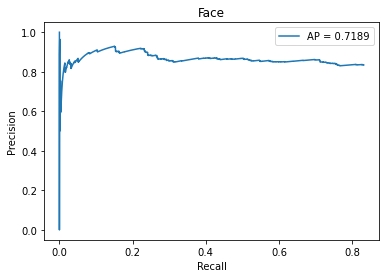

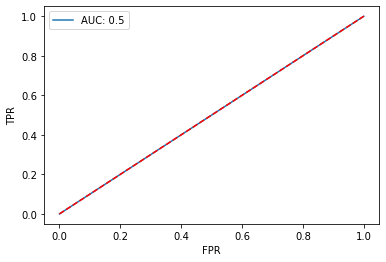

----------------

Eyes
AP: 0.2580565810203552
Number of true objects: 28681
Number of detections: 8718
Number of TP: 7962
Number of FP: 756


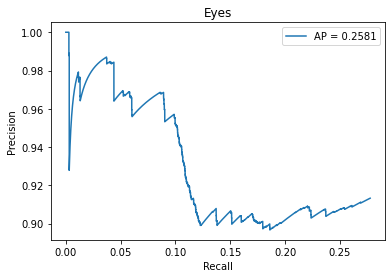

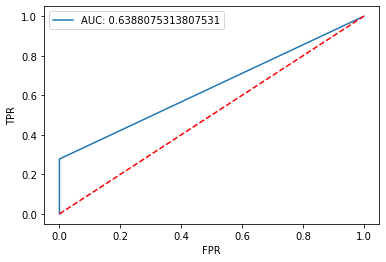

----------------

Mouth
AP: 0.002097571501508355
Number of true objects: 28651
Number of detections: 28661
Number of TP: 748
Number of FP: 27913


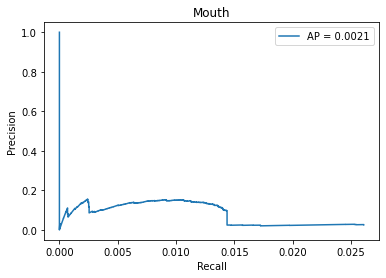

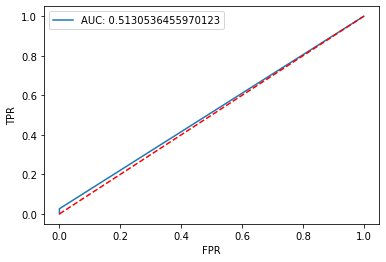

----------------

Glasses
AP: 0.8426981568336487
Number of true objects: 19828
Number of detections: 16880
Number of TP: 16721
Number of FP: 159


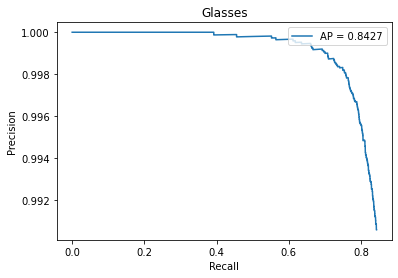

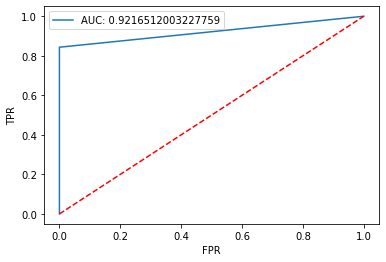

----------------

Cellphone
AP: 0.85854172706604
Number of true objects: 4457
Number of detections: 4992
Number of TP: 3886
Number of FP: 1106


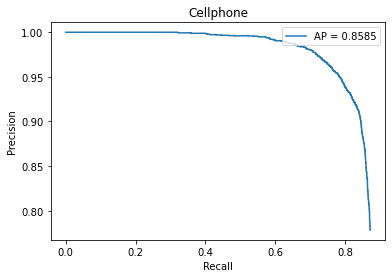

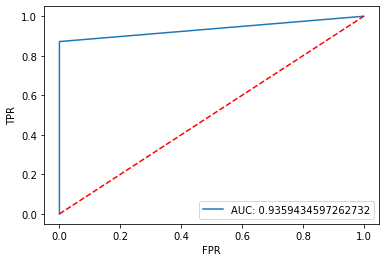

----------------



In [24]:
for obj_type in df['obj_type'].unique():
    AP, num_true_objects, num_detections, TP_cnt, FP_cnt, precisions, recalls = get_metrics(df, obj_type)
    print(obj_type)
    print(f'AP: {AP}')
    print(f'Number of true objects: {num_true_objects}')
    print(f'Number of detections: {num_detections}')
    print(f'Number of TP: {TP_cnt}')
    print(f'Number of FP: {FP_cnt}')
    plot_pr_curve(precisions, recalls, title=obj_type)
    y_true, y_proba = get_gt_and_proba(df, obj_type)
    plot_roc_curve(y_true, y_proba)
    print('----------------\n')

Статистики на датасете без лейбла 'Unknown'

Face
AP: 0.7215055227279663
Number of true objects: 24374
Number of detections: 24260
Number of TP: 20291
Number of FP: 3969


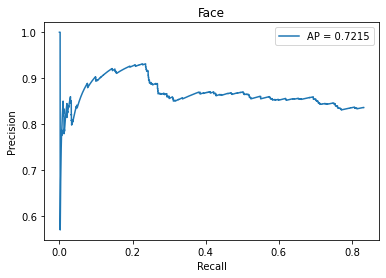

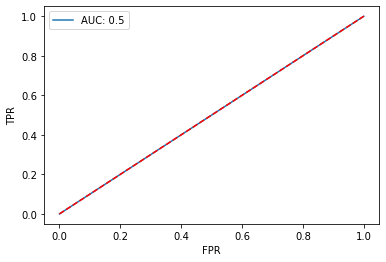

----------------

Eyes
AP: 0.31566938757896423
Number of true objects: 18591
Number of detections: 6539
Number of TP: 6142
Number of FP: 397


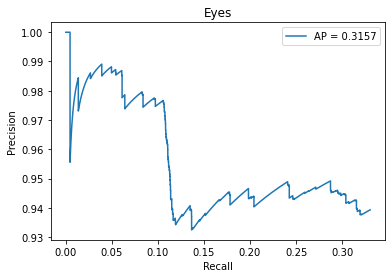

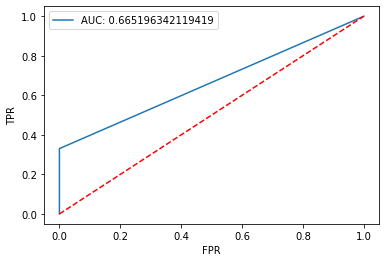

----------------

Mouth
AP: 0.001750383758917451
Number of true objects: 27920
Number of detections: 27976
Number of TP: 695
Number of FP: 27281


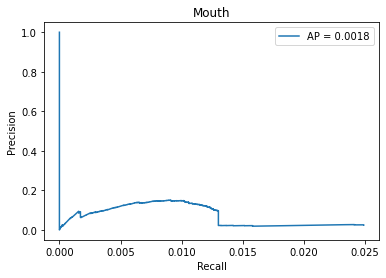

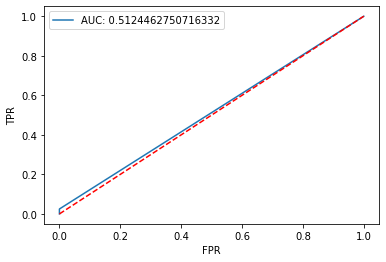

----------------

Glasses
AP: 0.9471849799156189
Number of true objects: 11865
Number of detections: 11371
Number of TP: 11244
Number of FP: 127


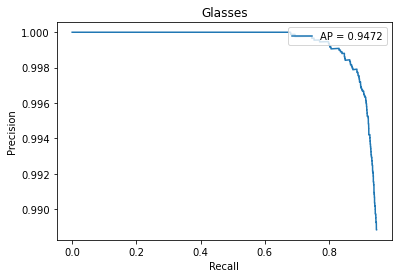

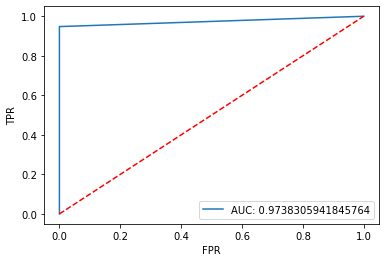

----------------

Cellphone
AP: 0.8709898591041565
Number of true objects: 4223
Number of detections: 4837
Number of TP: 3732
Number of FP: 1105


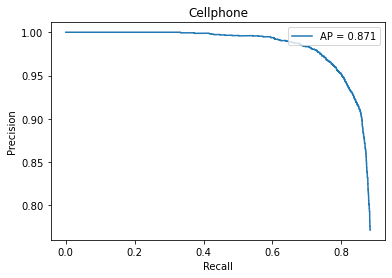

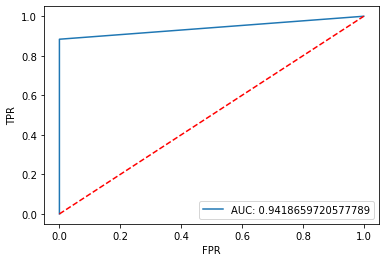

----------------



In [25]:
for obj_type in df['obj_type'].unique():
    AP, num_true_objects, num_detections, TP_cnt, FP_cnt, precisions, recalls = get_metrics(df[df['label'] != 'Unknown'], obj_type)
    print(obj_type)
    print(f'AP: {AP}')
    print(f'Number of true objects: {num_true_objects}')
    print(f'Number of detections: {num_detections}')
    print(f'Number of TP: {TP_cnt}')
    print(f'Number of FP: {FP_cnt}')
    plot_pr_curve(precisions, recalls, title=obj_type)
    y_true, y_proba = get_gt_and_proba(df[df['label'] != 'Unknown'], obj_type)
    plot_roc_curve(y_true, y_proba)
    print('----------------\n')